[![Open notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/afondiel/computer-vision-challenge/blob/main/L2_03_AI_Powered_Image_Restoration_and_Enhancement/notebooks/AI_Image_Restoration_Enhancement_T2_Denoising_DeepInv.ipynb)

#  AI Image Restoration and Enhancement: **Denoising** using [Deep Inverse](https://deepinv.github.io/deepinv/)

### Overview

Remove noise from an image while preserving the underlying details.

- **Popular Denoising Datasets**:
  - BSD500, Set12, Urban100, DIV2K (Diverse 2K), KODAK, ***DND (Darmstadt Noise Dataset)***...
  - [Full list](https://paperswithcode.com/datasets?task=image-denoising)
- **Custom test Dataset:** [afondiel/dummy_images - Hugging Face](https://huggingface.co/datasets/afondiel/dummy_images)
- **SOTA Models**: DnCNN, FFDNet, MemNet, RED-Net, VDN, Noise2Noise, BM3D, WNNM, SwinIR, NAFNet, ***[DDPM](https://hojonathanho.github.io/diffusion/)***
  - Please refer to this [Benchmarking](https://github.com/afondiel/computer-vision-challenge/blob/main/L2_03_AI_Powered_Image_Restoration_and_Enhancement/docs/Image_Restoration_Enhancement_Model_Benchmark.md) to see the top SOTA models for denoising tasks.


> **IMPORTANT:**\
> For the purpose of the entire project ([**Computer Vision Challenge**](https://github.com/afondiel/computer-vision-challenge)), we leverage Pre-trained Model in order to make the project accessible to all, while focusing on the performance and outcome of multiple models.
> - We'll be using pre-trained model from **[Hugging Face Hub](https://huggingface.co/models)** (for stability and safety), Github and other **public python libraries**


#### Install dependencies

In [2]:
# Install HF necessary libraries
!pip install accelerate transformers gradio datasets -U

In [3]:
## Install pytorch multimodality frameworks & model library
!pip install torch torchvision torchaudio fastai timm -U

  Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl (779.1 MB)
  Using cached torchvision-0.18.1-cp310-cp310-manylinux1_x86_64.whl (7.0 MB)
  Using cached torchaudio-2.3.1-cp310-cp310-manylinux1_x86_64.whl (3.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 10.0 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0+cu121
    Uninstalling torch-2.3.0+cu121:
      Successfully uninstalled torch-2.3.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.0+cu121
    Uninstalling torchvision-0.18.0+cu121:
      Successfully uninstalled torchvision-0.18.0+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.3.0+cu121
    Uninstal

In [4]:
# install DeepInverse
!pip install deepinv

  Using cached deepinv-0.2.0-py3-none-any.whl (255 kB)
  Using cached hdf5storage-0.1.19-py2.py3-none-any.whl (53 kB)
  Using cached einops-0.8.0-py3-none-any.whl (43 kB)
  Using cached wandb-0.17.4-py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.1/302.1 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.5 MB/s eta 0:00:00


In [16]:
# Import necessary libraries
import os
import sys
import numpy as np
import torch
import torchvision
import deepinv as dinv
import tensorflow as tf
import cv2
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display
# solve bug cv2.imshow
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

#  HF libraries & API
from datasets import load_dataset, Dataset, DatasetDict
from transformers import Pipeline


#### Load test datasets from  Hugging Face
> **IMPORTANT**:
> HF may require a token for secure dataset access. Follow the instructions below to load your own valid token if needed.

In [17]:
# Uncomment the line below to import necessary libraries
# from huggingface_hub import notebook_login, login

# To authenticate with Hugging Face Hub choose one of the 2 options below:

# 1. Interactive login (recommended for notebooks)
# notebook_login()  # This will open a browser window for login

# 2. Non-interactive login (if you have the token ready)
# login(token="HF_TOKEN_W")

#### Preprocessing and transformations

In [26]:
def get_input_images(dataset):
  # Extract images
  image_list = []

  for idx, example in enumerate(dataset['test']):  # Assuming the dataset has a 'test' split
    id = example['index'] ## features ==> examples
    im = example['image']
    # print(id)
    # print(im)

    if isinstance(im, str):
        img = Image.open(im)
    elif isinstance(im, dict):
        img = Image.open(BytesIO(requests.get(im['path']).content))
    # Handle the case when 'im' is already a PIL Image
    elif isinstance(im, Image.Image):
        img = im
    else:
        raise ValueError("Invalid image format")

    # Append the image to the list
    image_list.append(img)
  return image_list


In [19]:
# Load custom dataset from HF
ds = load_dataset("afondiel/dummy_images")
print(ds)
# $$$ DEBUG $$$$
# print(ds.items())
# print(ds['test'])
# print(type(ds['test']))
# print(ds['test'].features['index'])
# print(ds['test'].features['image'])
# print(ds['test'].num_rows)
# print(type(ds))



DatasetDict({
    test: Dataset({
        features: ['index', 'image'],
        num_rows: 6
    })
})


In [20]:

# Load and preprocess the image
def preprocess_image(image_path):
    # image = Image.open(image_path).convert("RGB")
    image = image_path.convert("RGB")
    image = image.resize((256, 256))
    image = np.array(image).astype(np.float32) / 255.0
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
    return image_tensor

# Display the image
def display_image(image_tensor, title="Image"):
    image = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)
    image_pil = Image.fromarray(image)
    image_pil.show(title=title)


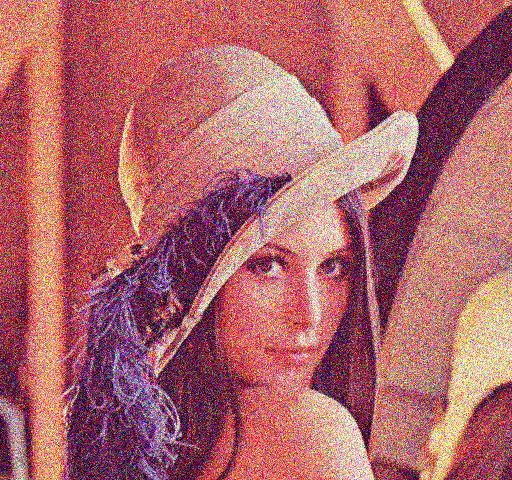

In [21]:
# get input images
input_imgs = get_input_images(ds)
noisy_image = input_imgs[3]
# print(noisy)
display(noisy_image)

#### Load your own dataset/image/photos

In [22]:
# Download the image using curl + opencv
# !curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
# !curl -o hendrix.jpg https://i.etsystatic.com/23861797/r/il/183b6d/3594587418/il_570xN.3594587418_fqp8.jpg

# # input_img = cv2.imread('logo.png')
# input_img = cv2.imread('hendrix.jpg')
# cv2_imshow(input_img)

#### Inference pretrained denoising models from Deeep Inverse

In [23]:

# Path to your noisy image
# image_path = "path_to_your_noisy_image.jpg"
noisy_image = preprocess_image(noisy_image).cuda()

noisy_image.shape

torch.Size([1, 3, 256, 256])

In [24]:
# Load DRUNet model
denoiser = dinv.models.DRUNet().cuda()

# Denoise the image using DRUNet
sigma = 0.1  # Adjust the noise level as required
with torch.no_grad():
    denoised_image = denoiser(noisy_image, sigma)

Downloading: "https://huggingface.co/deepinv/drunet/resolve/main/drunet_deepinv_color.pth?download=true" to /root/.cache/torch/hub/checkpoints/drunet_deepinv_color.pth
100%|██████████| 125M/125M [00:00<00:00, 385MB/s]


#### Visualization and Analysis

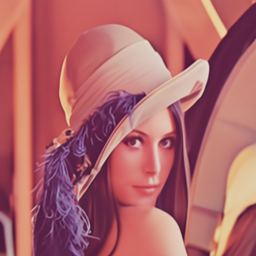

In [25]:
# Remove the batch dimension before converting to PIL Image
new_denoised_image= torchvision.transforms.functional.to_pil_image(denoised_image.squeeze(0))

# display_image(denoised_image_pil)
new_denoised_image

## References

**Docs:**

- [Deep Inverse Doc](https://deepinv.github.io/deepinv/)

- [AI Image Restoration](https://en.wikipedia.org/wiki/Image_restoration_by_artificial_intelligence)
- *Denoising:*
  - [Brief review of image denoising techniques](https://vciba.springeropen.com/articles/10.1186/s42492-019-0016-7)
  - [Denoising Techniques - Basics](https://iq.opengenus.org/image-denoising-and-image-processing-techniques/)
  - [Methods for image denoising using **CNN** - 2021](https://d-nb.info/1242356061/34)

  - [Denoising Diffusion Probabilistic Models (DDPM)](https://huggingface.co/docs/diffusers/v0.17.1/api/schedulers/ddpm)
    - paper: https://arxiv.org/pdf/2010.02502



**Datasets:**
- https://paperswithcode.com/datasets?task=image-denoising

- [Awesome Datasets for Super-Resolution: Introduction and Pre-processing - 2023](https://openmmlab.medium.com/awesome-datasets-for-super-resolution-introduction-and-pre-processing-55f8501f8b18)

ISR:
- DIV2K

[Enhanced Deep Residual Networks for Single Image Super-Resolution - paper](https://arxiv.org/pdf/1707.02921)
- DF2K

Real-ESRGAN:
- DF2K_OST

face super resolution:
- [FFHQ](https://paperswithcode.com/dataset/ffhq) and [CelebA-HQ](https://)

**Models:**

ISR Resources:
- [Image Super Resolution (ISR) github project with tf](https://github.com/idealo/image-super-resolution)
- [Paper with Code:](https://paperswithcode.com/paper/residual-dense-network-for-image-super)
  - paper: [Residual Dense Network for Image Super-Resolution CVPR 2018](https://openaccess.thecvf.com/content_cvpr_2018/papers/Zhang_Residual_Dense_Network_CVPR_2018_paper.pdf)

  - code: [RDN - @yulunzhang](https://github.com/yulunzhang/RDN)

Denoising:

Resnet
- [Resnet18 paper - Deep Residual Learning for Image Recognition: @Microsoft Research](https://arxiv.org/pdf/1512.03385)
- [U-Net Explained - paper with Code](https://paperswithcode.com/method/u-net)

Real-ESRGAN:
- Paper: [Real-ESRGAN: Training Real-World Blind Super-Resolution with Pure Synthetic Data](https://arxiv.org/pdf/2107.10833)
- [HF Space](https://huggingface.co/spaces/akhaliq/Real-ESRGAN)


Inpainting:

Deoldify:
- [deoldify.ai](https://deoldify.ai/)
- [colorizer](https://deepai.org/machine-learning-model/colorizer)

ESRGAN:

[Enhanced Super-Resolution Generative Adversarial Networks - paper 2018](https://arxiv.org/pdf/1809.00219)